In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import fastText

np.random.seed(123)

In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)

In [3]:
train['comment_text'] = train['comment_text'].astype(str)
test['comment_text'] = test['comment_text'].astype(str)

In [4]:
# training
#EMBEDDING_DIM = 300
#train['comment_text'].append(test['comment_text']).to_csv('train_text.csv', index=False, header=False)
#model = fasttext.skipgram('train_text.csv', 'model_skipgram', dim=EMBEDDING_DIM, thread=32)

In [5]:
fasttext_skipgram_emb = fastText.load_model('data/wiki.en.bin')
#fasttext_skipgram_emb = fasttext.load_model('model_skipgram.bin')
EMBEDDING_DIM = len(fasttext_skipgram_emb.get_word_vector('test'))

In [6]:
def sample():
    train_set = train.sample(frac=0.8)
    val_set = train.drop(train_set.index)
    
    class_weight = {0: len(train) / 2 / (len(train) - sum(train['toxic'])), 1: len(train) / 2 / sum(train['toxic']) }
    
    train_set = train_set.reset_index(drop=True)
    val_set = val_set.reset_index(drop=True)
    
    print(train_set['toxic'].describe())
    print(val_set['toxic'].describe())
    
    return train_set, val_set, class_weight

In [7]:
train_set, val_set, class_weight = sample()

count    127657.000000
mean          0.095772
std           0.294280
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64
count    31914.000000
mean         0.096133
std          0.294779
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: toxic, dtype: float64


In [8]:
from keras.preprocessing import text, sequence

max_features = 20000
maxlen = 256

#tokenizer = text.Tokenizer(num_words=max_features)
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train['comment_text'].append(test['comment_text']))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
r_word_index = { v:k for k, v in tokenizer.word_index.items()}
max_features = len(r_word_index)+1
print(max_features)

394788


In [10]:
X_tr = sequence.pad_sequences(tokenizer.texts_to_sequences(train_set['comment_text']), maxlen=maxlen)
X_va = sequence.pad_sequences(tokenizer.texts_to_sequences(val_set['comment_text']), maxlen=maxlen)
X_te = sequence.pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen=maxlen)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#other = ["severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_tr = train_set[list_classes]
y_va = val_set[list_classes]

In [11]:
"""
EMBEDDING_DIM = 300

from tqdm import tqdm

embeddings_index = {}
f = open("data/glove.6B.300d.txt".format(EMBEDDING_DIM))
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
"""

'\nEMBEDDING_DIM = 300\n\nfrom tqdm import tqdm\n\nembeddings_index = {}\nf = open("data/glove.6B.300d.txt".format(EMBEDDING_DIM))\nfor line in tqdm(f):\n    values = line.split()\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype=\'float32\')\n    embeddings_index[word] = coefs\nf.close()\n\nprint(\'Found %s word vectors.\' % len(embeddings_index))\n'

In [12]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_skipgram_emb.get_word_vector(word)
    """
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    """

In [21]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D, Average, Lambda, RepeatVector, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU, Conv1D, Reshape, MaxPooling1D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.constraints import non_neg, unit_norm

DROPOUT=0.

def mixing_layer(pred, emb):
    x = RepeatVector(len(list_classes))(pred)
    x = Lambda(lambda x: x * (np.ones([len(list_classes), len(list_classes)]) - np.eye(len(list_classes))))(x)
    c = Concatenate()([emb, x])
    return c


def split_dense(emb_layer, activation):
    k = []
    for i in range(len(list_classes)):
        k.append(Lambda(lambda x: x[:,i,:])(emb_layer))
    k = [Dense(1, activation=activation)(s) for s in k]
    return Concatenate()(k)    

import tensorflow as tf

def roc_auc_score(y_true, y_pred):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):

        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)

        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.2
        p     = 3

        difference = tf.zeros_like(pos * neg) + pos - neg - gamma

        masked = tf.boolean_mask(difference, difference < 0.0)

        return tf.reduce_sum(tf.pow(-masked, p))

def get_model_mix_layer():
    inp = Input(shape=(maxlen, ))
    
    emb = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
    
    gru = Bidirectional(GRU(64, recurrent_dropout=DROPOUT, dropout=DROPOUT))(emb)
    #gru = Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=DROPOUT, dropout=DROPOUT))(emb)
    #gru = Bidirectional(GRU(128, recurrent_dropout=0.2, dropout=0.2))(gru)
    
    final = Dense(128, activation='selu')(gru)
    final = Dropout(DROPOUT)(final)
    final = Dense(128, activation='selu')(final)
    final = Dropout(DROPOUT)(final)
    final = Dense(6, activation='sigmoid')(final)

    model = Model(inputs=inp, outputs=final)
    model.compile(loss=roc_auc_score,
                  optimizer='adam',
                  metrics=['accuracy', 'binary_crossentropy'])

    return model

model = get_model_mix_layer()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 256, 300)          118436400 
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               140160    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [24]:
from keras.callbacks import Callback
from sklearn import metrics

np.random.seed(777)
batch_size = 1024
epochs = 2000

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
    
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):        
        y_pred = self.model.predict(self.x, batch_size=batch_size*2)
        roc = metrics.roc_auc_score(self.y, y_pred)
        
        y_pred_val = self.model.predict(self.x_val, batch_size=batch_size*2)
        roc_val = metrics.roc_auc_score(self.y_val, y_pred_val)      
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return   

file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks_list = [checkpoint, early, roc_callback(training_data=(X_tr, y_tr),validation_data=(X_va, y_va))]
model.fit(
    X_tr,
    y_tr, 
    class_weight=None, 
    validation_data=(X_va, y_va), 
    shuffle=True, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
)

Train on 127657 samples, validate on 31914 samples
Epoch 1/2000
roc-auc: 0.984 - roc-auc_val: 0.977                                                                                                    
127657/127657 [==============================] - 290s 2ms/step - loss: 569.1688 - acc: 0.9082 - binary_crossentropy: 0.6427 - val_loss: 622.1115 - val_acc: 0.9378 - val_binary_crossentropy: 0.6570
Epoch 2/2000
roc-auc: 0.9867 - roc-auc_val: 0.9795                                                                                                    
127657/127657 [==============================] - 290s 2ms/step - loss: 472.8500 - acc: 0.9109 - binary_crossentropy: 0.6519 - val_loss: 581.8433 - val_acc: 0.9034 - val_binary_crossentropy: 0.6443
Epoch 3/2000
roc-auc: 0.9883 - roc-auc_val: 0.9808                                                                                                    
127657/127657 [==============================] - 290s 2ms/step - loss: 414.6661 - acc: 0.9206 - binary_c

KeyboardInterrupt: 

In [25]:
model.load_weights(file_path)


pred = model.predict(X_va, batch_size=128)
int_pred = pred >= 0.5

toxic
roc:		0.97591
f1:		0.24142
precision:	0.13731
recall:		0.99870
log loss:	1
tp:		3064
fp:		19251
tn:		9595
fn:		4
tpr:		0.999
fpr:		0.667


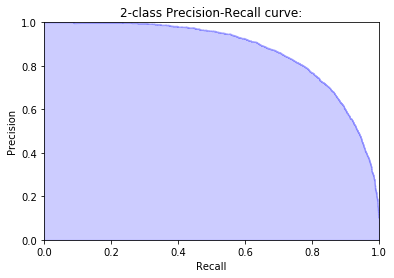

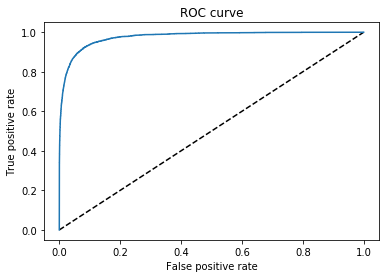

severe_toxic
roc:		0.99087
f1:		0.11512
precision:	0.06109
recall:		0.99692
log loss:	1
tp:		324
fp:		4980
tn:		26609
fn:		1
tpr:		0.997
fpr:		0.158


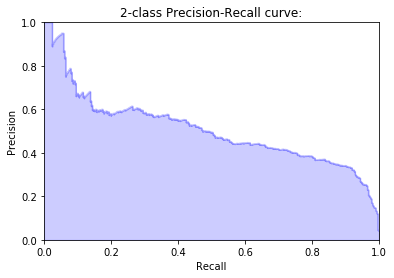

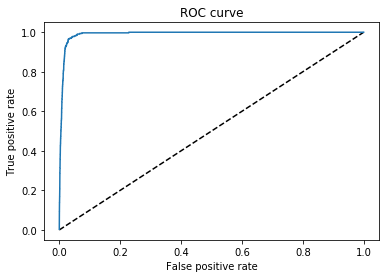

obscene
roc:		0.99068
f1:		0.20673
precision:	0.11529
recall:		0.99940
log loss:	1
tp:		1659
fp:		12731
tn:		17523
fn:		1
tpr:		0.999
fpr:		0.421


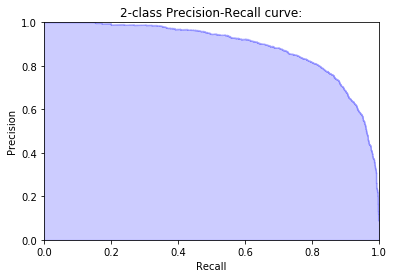

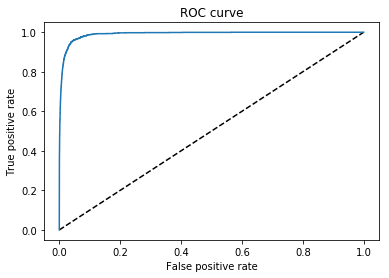

threat
roc:		0.96781
f1:		0.02458
precision:	0.01245
recall:		0.97778
log loss:	1
tp:		88
fp:		6982
tn:		24842
fn:		2
tpr:		0.978
fpr:		0.219


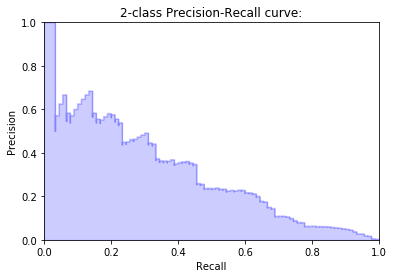

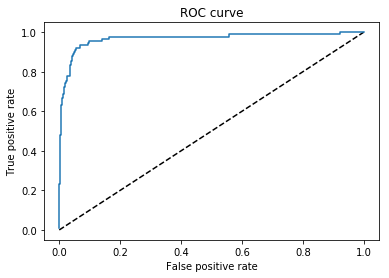

insult
roc:		0.98274
f1:		0.17450
precision:	0.09560
recall:		0.99937
log loss:	1
tp:		1578
fp:		14929
tn:		15406
fn:		1
tpr:		0.999
fpr:		0.492


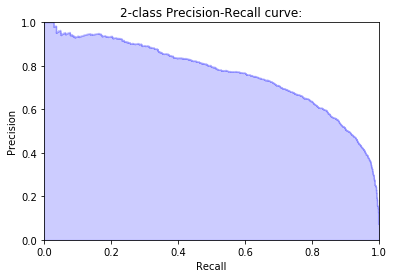

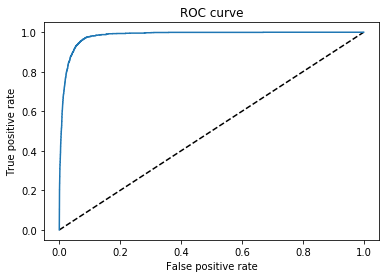

identity_hate
roc:		0.97676
f1:		0.05981
precision:	0.03084
recall:		0.98456
log loss:	1
tp:		255
fp:		8013
tn:		23642
fn:		4
tpr:		0.985
fpr:		0.253


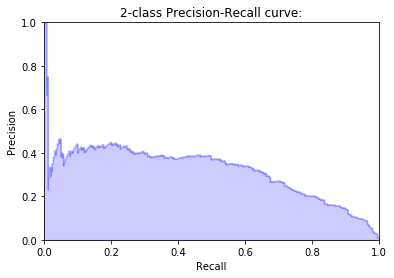

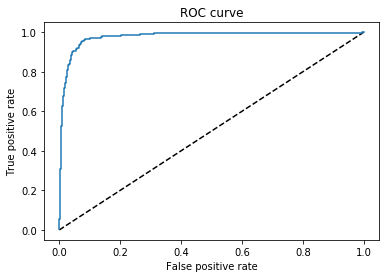

In [26]:
from sklearn import metrics

for i, c in enumerate(list_classes):
    print(c)
    print("roc:\t\t%.5f" % metrics.roc_auc_score(val_set[c], pred[:,i]))
    print("f1:\t\t%.5f" % metrics.f1_score(val_set[c], int_pred[:,i]))
    print("precision:\t%.5f" % metrics.precision_score(val_set[c], int_pred[:,i]))
    print("recall:\t\t%.5f" %metrics.recall_score(val_set[c], int_pred[:,i]))
    print("log loss:\t%.f" %metrics.log_loss(val_set[c], pred[:,i]))

    m = metrics.confusion_matrix(val_set[c], int_pred[:,i])
    tp = m[1,1]
    fp = m[0,1]
    tn = m[0,0]
    fn = m[1,0]
    print("tp:\t\t%d"%tp)
    print("fp:\t\t%d"%fp)
    print("tn:\t\t%d"%tn)
    print("fn:\t\t%d"%fn)
    
    print("tpr:\t\t%.3f"%(tp / (tp+fn)))
    print("fpr:\t\t%.3f"%(fp / (fp+tn)))

    
    precision, recall, threshold = metrics.precision_recall_curve(val_set[c], pred[:,i])
    plt.figure(0)
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
         color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve:')
    plt.show()
    
    fpr, tpr, _ = metrics.roc_curve(val_set[c], pred[:,i])
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
for i, row in val_set[(pred[:, 0] <= 0.1) & (val_set['toxic'] == 1)].sample(1).iterrows():
    print(row['comment_text'])
    print(row)

In [ ]:
model.load_weights(file_path)
sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission[list_classes] = y_test

sample_submission.to_csv("baseline.csv", index=False)

In [27]:
model.load_weights(file_path)

y_test = model.predict([X_te], batch_size=2048)

sample_submission = pd.read_csv("./data/sample_submission.csv")
sample_submission[list_classes] = y_test
sample_submission.to_csv("baseline.csv", index=False)

In [ ]:
tokenizer.word_counts['pagan']
tokenizer.word_counts